## Overview

This code uses a GPU to implement a multerlayer perceptron (MLP), which is the simplest artificail neural network (ANN). The MLP is implemented on both the GPU and the CPU, and their rutimes can be compared. Depending on the GPU being used and the size of the network, I have observed up to a little over 3100x speedup. There are four sections in theis notebook: CODE, RUN, ANALYZE, and DEVICE INFO.

* The CODE section holds all of the C/CUDA code necessary for the implementation aside from a main file. 

* The RUN section has six different main files that can be used. The files either run only on the GPU, only on the CPU, or on both. Within these sections there is a "main" and a "statistical." The main option allows an individual run with customizeable amount of hidden layers with customizeable amounts of nodes. The statistical options run a large series of many networks. Information about the runs are printed on the screen as well as stored in a csv. At the end of each statistical section is some python code to load the csv as a pandas dataframe.

* The ANALYZE section has a combination of python and R code to take the generated dataframes and graph visualizations analyze the data.

* Finally the DEVICE INFO section has C code that checks the gpu being used. This is helpful because the speedup is highly dependent on the hardware and if results seem underwhelming it might help to see what device is being used.

Note: run the the cells containing the C code, then run the shell script that compiles and runs it. Any C code that hasn't been loaded by running its cell cannot be compiled. The CODE section can all be loaded at once by collapsing the sectiona and pressing the run button to load to it all.

#CODE

Overview of code

- The header file contains mostly the structs for holding data
- The setup file controls the loading of data and the setting up/ tearing down of the neural networks. Note that the size of the network is not specified here, but rather is specified by the main
- The helper file just holds some helper functions
- The kernels file, as the name suggests, holds all of the cuda kernels
- The algorithms file holds the functions that organize and run the training. The cpu function does most of the work itself while the gpu function mostly just calls the kernels in order.

## Header File

This header file stores the TILEWIDTH constant and the structs. The structs hold the information for the neural networks and data. The sigmoid helper function is also declared here as it is used by multiple files.

In [6]:
%%writefile header.h

#ifndef header_h
#define header_h

#define TILE_WIDTH 8

__host__ __device__ double sigmoid(double x);

// structs
struct data_input{
	double * I;
	double * O;
	double * W;
	int * layers;
	int L;
	int numTrainingPairs;
	int num_nodes;
	int num_weights;
}input;

struct cpu_network {
    // data
	double * I;
    double * O;
    int * layers;

    // network
	double * Y;
	double * D;
	int * nodes_indices;
	double * gradient;
	double * W;
	int * w_indices;
}cpu;

struct gpu_network {
    // data
	double * I;
    double * O;
    int * layers;
	
    // network
    double * Y;
	double * D;
	int * nodes_indices;
	double * W;
	int * w_indices;
    int batch_size;
	int last_layer_index;
	int last_layer_size;
	
	// block and grids
	dim3 block;
	dim3 * forward_grid;
	dim3 * delta_grid;
	dim3 * update_grid;
}gpu;

#endif

Writing header.h


## Setup

There are three types of functions in this setup file.

1. Data loading
    *   Data refers to the training pair information and any information that is needed for the networks to set themselves up.
    *   This data is stored in a struct named input, which will be used for setting up the networks.
2. Network setup
    *   The network setup creates the arrays for the weights, the node values, and the delta values, as well as loads the data that was stored in the input struct.
    *   All of the arrays are linearized forms of multi-dimensional arrays. The beginning index of the matrices have to be stored beforehand as the matrices are of different sizes. The Y and D arrays have the exact same size corresponding to the nodes (and for the gpu also the amount of training pairs being run). Because of this, both of their indices are stored in the array "nodes_indices." The indices of the weights array are stored in the "w_indices" array.
    *   The gpu also needs to have the grid and block dimensions for each run calculated and stored beforehand. This is because they stay the same every run for a given set of layers and number of training pairs. Therefore, recalculating them while running the gpu algorithm is a massive waste.
    *   Finally, notice that for the gpu I included a field called "batch_size." In the kernels this is used as the dimension of the matrix that corresponds to how many training pairs will be ran. Because of this, the kernels are able to do mini-batch; however, I haven't outfitted the setup to accomadate for that as it was asside from the purpose of this project. Because of this, the batch_size is set to the total number of training pairs. All training pairs will be ran on the gpu as one single matrix. This is feasible up until there are more inputs than are allowed in the cuda dimensions.
2. Memory freeing
    *   Self-explanitory


In [7]:
%%writefile setup.cu

#include "header.h"

int data_load(int * layers, int L) {
	  
    // hardcoded example data, this section could be replaced by file read
    double I[] = {
		0,0, 0,1, 0,2, 0,3, 0,4, 0,5, 0,6, 0,7,
		1,0, 1,1, 1,2, 1,3, 1,4, 1,5, 1,6, 1,7,
		2,0, 2,1, 2,2, 2,3, 2,4, 2,5, 2,6, 2,7,
		3,0, 3,1, 3,2, 3,3, 3,4, 3,5, 3,6, 3,7,
		4,0, 4,1, 4,2, 4,3, 4,4, 4,5, 4,6, 4,7,
		5,0, 5,1, 5,2, 5,3, 5,4, 5,5, 5,6, 5,7,
		6,0, 6,1, 6,2, 6,3, 6,4, 6,5, 6,6, 6,7,
		7,0, 7,1, 7,2, 7,3, 7,4, 7,5, 7,6, 7,7
	};
	    
	double O[] = {
		1,1,1,1,1,1,1,1,
		1,1,1,1,1,1,1,1,
		1,1,0,1,1,1,1,1,
		1,0,0,0,1,1,1,1,
		1,0,0,0,0,0,1,1,
		0,0,0,0,0,0,1,1,
		0,0,0,0,0,1,1,1,
		0,0,0,1,1,1,1,1 
	};

	int numTrainingPairs = 64;


	// data loading
	int pairs_bytes = numTrainingPairs * layers[0] * sizeof(double);
    input.I = (double *)malloc(pairs_bytes);
	memcpy(input.I, I, pairs_bytes);

	int exp_bytes = numTrainingPairs * layers[L] * sizeof(double);
    input.O = (double *)malloc(exp_bytes);
	memcpy(input.O, O, exp_bytes);

	int layers_bytes = (L + 1) * sizeof(int);
    input.layers = (int *)malloc(layers_bytes);
    memcpy(input.layers, layers, layers_bytes);

	input.L = L;
	input.numTrainingPairs = numTrainingPairs;

	// find number of elements	
	int num_weights = 0;
    for(int i = 0; i < L; i++)
        num_weights += (layers[i] + 1) * layers[i + 1];
	
	int num_nodes = 0;
	for(int i = 1; i <= L; i++)
		num_nodes += layers[i];

	input.num_nodes = num_nodes;
	input.num_weights = num_weights;

	// create weights
	time_t t;
    srand((unsigned) time(&t));
    double * weights = (double *)calloc(num_weights, sizeof(double));
    for(int i = 0; i < num_weights; i++)
        weights[i] = (double)rand() / (double)RAND_MAX - 0.5;

	input.W = weights;

	return numTrainingPairs;
}


void cpu_setup() {

	// get necessary data	  
	int L = input.L;
	int * layers = input.layers;
	int num_nodes = input.num_nodes;
	int num_weights = input.num_weights;
	int numTrainingPairs = input.numTrainingPairs;
	
	// data setup
	int layers_bytes = (L + 1) * sizeof(int);
    cpu.layers = (int *)malloc(layers_bytes);
    memcpy(cpu.layers, input.layers, layers_bytes);

	int inp_bytes = numTrainingPairs * cpu.layers[0] * sizeof(double);
    cpu.I = (double *)malloc(inp_bytes);
	memcpy(cpu.I, input.I, inp_bytes);

	int exp_bytes = numTrainingPairs * input.layers[L] * sizeof(double);
    cpu.O = (double *)malloc(exp_bytes);
	memcpy(cpu.O, input.O, exp_bytes);

	// network setup
	double * Y = (double *)malloc(num_nodes * sizeof(double));
	double * D = (double *)malloc(num_nodes * sizeof(double));
	
	int * nodes_indices = (int *)calloc(L, sizeof(int));
	for(int i = 1; i < L; i++)
		nodes_indices[i] = nodes_indices[i-1] + layers[i];
	

	double * gradient = (double *)calloc(num_weights, sizeof(double));
	double * W = (double *)calloc(num_weights, sizeof(double));
	memcpy(W, input.W, num_weights * sizeof(double));
	
	int * w_indices = (int *)calloc(L, sizeof(int));
    for(int i = 1; i < L; i++)
        w_indices[i] = w_indices[i-1] + (layers[i-1] + 1) * layers[i];
	
	cpu.Y = Y;
	cpu.D = D;
	cpu.nodes_indices = nodes_indices;
	cpu.gradient = gradient;
	cpu.W = W;
	cpu.w_indices = w_indices;
}

void gpu_setup() {

	// get necessary input data
	int L = input.L;
	int * layers = input.layers;
	int num_weights = input.num_weights;
	int num_nodes = input.num_nodes;
	int numTrainingPairs = input.numTrainingPairs;
	
	// data setup
	int layers_bytes = (L + 1) * sizeof(int);
	cudaMalloc(&gpu.layers, layers_bytes);
	cudaMemcpy(gpu.layers, input.layers, layers_bytes, cudaMemcpyHostToDevice);

	int inp_bytes = numTrainingPairs * input.layers[0] * sizeof(double);
	cudaMalloc(&gpu.I, inp_bytes);
	cudaMemcpy(gpu.I, input.I, inp_bytes, cudaMemcpyHostToDevice);

	int exp_bytes = numTrainingPairs * input.layers[L] * sizeof(double);
	cudaMalloc(&gpu.O, exp_bytes);
	cudaMemcpy(gpu.O, input.O, exp_bytes, cudaMemcpyHostToDevice);

	gpu.batch_size = numTrainingPairs;
	int batch_size = numTrainingPairs;

	// network setup
	int nodes_bytes = num_nodes * batch_size * sizeof(double);
	cudaMalloc(&gpu.Y, nodes_bytes);
	cudaMemset(gpu.Y, 0, nodes_bytes);
	cudaMalloc(&gpu.D, nodes_bytes);
	cudaMemset(gpu.D, 0, nodes_bytes);

	int sum = 0;
	int gpu_nodes_indices[L];
	gpu_nodes_indices[0] = 0;
	for(int i = 1; i < L; i++) {
		sum += layers[i];
		gpu_nodes_indices[i] = sum * batch_size;
	}

	gpu.last_layer_index = gpu_nodes_indices[L-1];
	gpu.last_layer_size = layers[L];
	
	int indices_bytes = L * sizeof(int);
	cudaMalloc(&gpu.nodes_indices, indices_bytes);
	cudaMemcpy(gpu.nodes_indices, gpu_nodes_indices, indices_bytes, cudaMemcpyHostToDevice);

	int w_bytes = num_weights * sizeof(double);
	cudaMalloc(&gpu.W, w_bytes);
	cudaMemcpy(gpu.W, input.W, w_bytes, cudaMemcpyHostToDevice);

	int * w_indices = (int *)calloc(L, sizeof(int));
    for(int i = 1; i < L; i++)
        w_indices[i] = w_indices[i-1] + (layers[i-1] + 1) * layers[i];

	cudaMalloc(&gpu.w_indices, indices_bytes);
	cudaMemcpy(gpu.w_indices, w_indices, indices_bytes, cudaMemcpyHostToDevice);


	// kernel grids and blocks
	gpu.block = dim3(TILE_WIDTH, TILE_WIDTH);
	int gridx = ceil((float)batch_size/TILE_WIDTH);
	
	gpu.forward_grid = (dim3 *)malloc(L * sizeof(dim3));
	for(int r = 0; r < L; r++)
		gpu.forward_grid[r] = dim3(gridx, ceil((float)(layers[r+1])/TILE_WIDTH));

	gpu.delta_grid = (dim3 *)malloc(L * sizeof(dim3));
	for(int r = 1; r < L; r++)
		gpu.delta_grid[r] = dim3(gridx, ceil((float)layers[r]/TILE_WIDTH));

	gpu.update_grid = (dim3 *)malloc(L * sizeof(dim3));
	for(int r = 0; r < L; r++)
		gpu.update_grid[r] = dim3(ceil((float)(layers[r] + 1)/TILE_WIDTH), ceil((float)layers[r+1]/TILE_WIDTH));


	// debug section
}

void free_input() {
	free(input.I);
	free(input.O);
	free(input.W);
	free(input.layers);
}

void free_cpu() {
    // cpu
    free(cpu.I);
    free(cpu.O);
    free(cpu.layers);

    free(cpu.Y);
	free(cpu.D);
	free(cpu.nodes_indices);
    free(cpu.gradient);
	free(cpu.W);
	free(cpu.w_indices);
}

void free_gpu() {
    // gpu
	cudaFree(gpu.I);
	cudaFree(gpu.O);
	cudaFree(gpu.layers);
	
    cudaFree(gpu.Y);
    cudaFree(gpu.D);
	cudaFree(gpu.nodes_indices);
	cudaFree(gpu.W);
	cudaFree(gpu.w_indices);

    free(gpu.forward_grid);
	free(gpu.delta_grid);
    free(gpu.update_grid);
}

Writing setup.cu


## Helpers

There are two helper functions
1. sigmoid
    *   This is the activation function we will use by both the cpu and gpu
2. printOutput
    *   Three columns are printed. First is the expected output, then is the output we achievied, and finally is the error (|expected-output|).

In [8]:
%%writefile helpers.cu

#include <stdio.h>
#include <sys/time.h>

__host__ __device__ double sigmoid(double x) {
    if(x < -709)
        return 0.0;
    
	if(x > 24)
		return 1.0;
	
    return 1.0 / (1.0 + exp(-x));
}


void printOutput(double * output, double * expected, int numTrainingPairs, int numIterations, int * layers, int L) {
    int numE = 0;
    double largest_cost = 0;
    printf("\nOuput values after %d iterations:\n", numIterations);
    for(int i = 0; i < numTrainingPairs; i++) {
        double greatest_local_cost = 0;
        for(int x = 0; x < layers[L]; x++) {
            double cost = abs(output[i * layers[L] + 0] - expected[i * layers[L] + 0]);
			if(cost > greatest_local_cost)
                greatest_local_cost = cost;
        }
				
        printf("| ");
                
        for(int x = 0; x < layers[L]; x++)
            printf("%.0f ", expected[i * layers[L] + x]);
                  
        printf("| ");
                
        for(int x = 0; x < layers[L]; x++)
            printf("%.3f ", output[i * layers[L] + x]);
                
        printf("| %.3f | ", greatest_local_cost);
                
        if(greatest_local_cost < 0.1) {
            printf("\n");
        } else {
            printf("*\n");
            numE++;
        }
                
        if(greatest_local_cost > largest_cost)
            largest_cost = greatest_local_cost;
    }
			
    printf("==> %d errors\n", numE);
    printf("==> %.3f largest cost\n", largest_cost);
}


double currentTime() {
   struct timeval now;
   gettimeofday(&now, NULL);

   return now.tv_sec + now.tv_usec/1000000.0;
}


Writing helpers.cu


## Kernels

While there are five kernels in this file, only three explanations need to be given. All three use the matrix multiplication algorithm for gpus that I am assuming the reader is comfortable with.

1. first_forward and forward
    *   These two kernels handle the forward propagation. They are nearly identicle. The first_forward kernel takes in the inputs array and treats it as a matrix; the output is stored in the first matrix of the Y array. The second kernel then uses the matrices in the Y array for the remaining layers. Due to how the input array was stored, we have to transpose it while multiplying in the first_forward kernel, hence the slight differnece between the kernels (aside from useing different inputs). 
    *   It may be asked why the Y array wasn't made larger and the input wasn't copied into Y so we only need to write one kernel. First, this made the data storage a little more confusing. Second, that extra work would only add time and redundant memory to the computation.
    *   At the end of both kernels, we check to see if we have passed the last layer. If so, we already have all of the threads and information ready to calculate the first layer of deltas and stores is at the end of the deltas array. Seeing as how these first deltas are calculated differently than the rest, this simplifies the delta process and is the best use of computing resources.
2. delta_propagation
    *   The first layer of deltas has been calculated, so this kernel propagates them backward layer by layer through matrix multiplication.
3. first_layer_update and update
    *   None of these kenrels need to be called synchronously, so the cpu will rapidly call them all. The first layer uses the input array so has to be treated a little differently, but beyond that the process is the matrix multiplication as previously described.

In [9]:
%%writefile kernels.cu

#include "header.h"

/*
	The Following two kernels are for forward propagation
	The first is for the first layer, which uses the training_pairs as
	input rather than the Y array, the second is for all layers after 
*/
__global__ void first_forward(double * I, double * W, double * Y, double * D, double * O, int batch_size, int * layers, int L) {
	__shared__ double WV[TILE_WIDTH][TILE_WIDTH];
	__shared__ double YV[TILE_WIDTH][TILE_WIDTH];
	
	const int in_nodes = layers[0];
	const int out_nodes = layers[1];
	
	const int tx = threadIdx.x;
	const int ty = threadIdx.y;
	const int col = blockIdx.x * TILE_WIDTH + tx;
	const int row = blockIdx.y * TILE_WIDTH + ty;
	
	double acc = 0;
	
	const int num_tiles = ceil((float)in_nodes/TILE_WIDTH);
	for(int m = 0; m < num_tiles; m++) {
		const int tile_col = m * TILE_WIDTH + tx;
		const int tile_row = m * TILE_WIDTH + ty;

		WV[ty][tx] = (tile_col < in_nodes && row < out_nodes) ? W[row * (in_nodes + 1) + tile_col+1] : 0;
		YV[ty][tx] = (tile_row < in_nodes && col < batch_size) ? I[col * in_nodes + tile_row] : 0;

		
		__syncthreads();
		
		for(int k = 0; k < TILE_WIDTH; k++)
			acc += WV[ty][k] * YV[k][tx];
		
		__syncthreads();
	}
	
	if(row >= out_nodes || col >= batch_size) return;

	double y = sigmoid(acc + W[row * (in_nodes + 1)]);
	const int index = row * batch_size + col;
	Y[index] = y;

	if(0 != L - 1) return;
	
	D[index] = y * ( 1 - y ) * ( y - O[index]);
}


__global__ void forward(int r, double * W, double * Y, double * D, double * O, int batch_size, int * layers, int L, int * w_indices, int * nodes_indices) {
	__shared__ double WV[TILE_WIDTH][TILE_WIDTH];
	__shared__ double YV[TILE_WIDTH][TILE_WIDTH];
	
	const int in_nodes = layers[r];
	const int out_nodes = layers[r+1];
	
	const int w_index = w_indices[r];
	int nodes_index = nodes_indices[r-1];
	
	const int tx = threadIdx.x;
	const int ty = threadIdx.y;
	const int col = blockIdx.x * TILE_WIDTH + tx;
	const int row = blockIdx.y * TILE_WIDTH + ty;
	
	double acc = 0;
	
	const int num_tiles = ceil((float)in_nodes/TILE_WIDTH);
	for(int m = 0; m < num_tiles; m++) {
		const int tile_col = m * TILE_WIDTH + tx;
		const int tile_row = m * TILE_WIDTH + ty;
		
		WV[ty][tx] = (tile_col < in_nodes && row < out_nodes) ? W[w_index + row * (in_nodes + 1) + tile_col+1] : 0;
		YV[ty][tx] = (tile_row < in_nodes && col < batch_size) ? Y[nodes_index + tile_row * batch_size + col] : 0;

		
		__syncthreads();
		
		for(int k = 0; k < TILE_WIDTH; k++)
			acc += WV[ty][k] * YV[k][tx];
		
		__syncthreads();
	}
	
	if(row >= out_nodes || col >= batch_size) return;

	nodes_index = nodes_indices[r];
	int index = row * batch_size + col;
	
	double y = sigmoid(acc + W[w_index + row * (in_nodes + 1)]);
	Y[nodes_index + index] = y;

	if(r != L - 1) return;
	
	D[nodes_index + index] = y * ( 1 - y ) * ( y - O[index]);
}


/*
	The next layer handles the calculation of the delta values for all but the last 
	layer, which was handled by the end of the forward propagation kernels
*/
__global__ void back_propagation(int r, double * W, double * D, double * Y, int batch_size, int * layers, int * w_indices, int * nodes_indices) {
	__shared__ double WV[TILE_WIDTH][TILE_WIDTH];
	__shared__ double DV[TILE_WIDTH][TILE_WIDTH];
	
	const int w_index = w_indices[r];
	const int d_index = nodes_indices[r];
	
	const int in_nodes = layers[r] + 1;
	const int out_nodes = layers[r+1];
	
	const int tx = threadIdx.x;
	const int ty = threadIdx.y;
	const int col = blockIdx.x * TILE_WIDTH + tx;
	const int row = blockIdx.y * TILE_WIDTH + ty;
	
	double acc = 0;
	
	const int num_tiles = ceil((float)in_nodes/TILE_WIDTH);	
	for(int m = 0; m < num_tiles; m++) {
		const int tile_col = m * TILE_WIDTH + tx;
		const int tile_row = m * TILE_WIDTH + ty;
		
		WV[ty][tx] = (tile_col < out_nodes && row < in_nodes-1) ? W[w_index + tile_col * in_nodes + row+1] : 0;
		DV[ty][tx] = (tile_row < out_nodes && col < batch_size) ? D[d_index + tile_row * batch_size + col] : 0;

		
		__syncthreads();
		
		for(int k = 0; k < TILE_WIDTH; k++)
			acc += WV[ty][k] * DV[k][tx];
		
		__syncthreads();
	}
	
	if(row >= in_nodes-1 || col >= batch_size) return;
	
	const int index = nodes_indices[r-1] + row * batch_size + col;
	double y = Y[index];	
	D[index] = y * (1 - y) * acc;
}

/*
	The final two layers are for the updating of the weights. The first kernel is for 
	updating the weights of the first layer, the second kernel is for all other layers
*/
__global__ void first_layer_update(double * D, double * I, double * W, float mu, int batch_size, int * layers) {
	__shared__ double DV[TILE_WIDTH][TILE_WIDTH];
	__shared__ double YV[TILE_WIDTH][TILE_WIDTH];
	
	// which layer we are working with
	const int in_nodes = layers[0] + 1;
	const int out_nodes = layers[1];
	
	// info for matrix mult
	const int tx = threadIdx.x;
	const int ty = threadIdx.y;
	const int col = blockIdx.x * TILE_WIDTH + tx;
	const int row = blockIdx.y * TILE_WIDTH + ty;
	
	double acc = 0;
	
	const int num_tiles = ceil((float)batch_size/TILE_WIDTH);
	for(int m = 0; m < num_tiles; m++) {
		const int tile_col = m * TILE_WIDTH + tx;
		const int tile_row = m * TILE_WIDTH + ty;
		
		DV[ty][tx] = (tile_col < batch_size && row < out_nodes) ? D[row * batch_size + tile_col] : 0;
		
		if(col == 0)
			YV[ty][tx] = 1;
		else 
			YV[ty][tx] = (tile_row < batch_size && col < in_nodes) ? I[tile_row * (in_nodes-1) + col-1] : 0;
		
		
		__syncthreads();
		
		for(int k = 0; k < TILE_WIDTH; k++)
			acc += DV[ty][k] * YV[k][tx];
		
		__syncthreads();
	}
	
	if(row >= out_nodes || col >= in_nodes) return;
	
	W[row * in_nodes + col] -= mu * acc;
}

__global__ void update(int r, double * D, double * Y, double * W, float mu, int batch_size, int * layers, int * w_indices, int * nodes_indices) {
	__shared__ double DV[TILE_WIDTH][TILE_WIDTH];
	__shared__ double YV[TILE_WIDTH][TILE_WIDTH];
	
	// which layer we are working with
	const int in_nodes = layers[r] + 1;
	const int out_nodes = layers[r+1];

	// indices
	const int d_index = nodes_indices[r];
	const int y_index = nodes_indices[r-1];
	
	// info for matrix mult
	const int tx = threadIdx.x;
	const int ty = threadIdx.y;
	const int col = blockIdx.x * TILE_WIDTH + tx;
	const int row = blockIdx.y * TILE_WIDTH + ty;
	
	double acc = 0;
	
	const int num_tiles = ceil((float)batch_size/TILE_WIDTH);
	for(int m = 0; m < num_tiles; m++) {
		const int tile_col = m * TILE_WIDTH + tx;
		const int tile_row = m * TILE_WIDTH + ty;
		
		DV[ty][tx] = (tile_col < batch_size && row < out_nodes) ? D[d_index + row * batch_size + tile_col] : 0;
		
		if(col == 0)
			YV[ty][tx] = 1;
		else 
			YV[ty][tx] = (tile_row < batch_size && col < in_nodes) ? Y[y_index + (col-1) * batch_size + tile_row] : 0;
		
		
		__syncthreads();
		
		for(int k = 0; k < TILE_WIDTH; k++)
			acc += DV[ty][k] * YV[k][tx];
		
		__syncthreads();
	}
	
	if(row >= out_nodes || col >= in_nodes) return;
	
	W[w_indices[r] + row * in_nodes + col] -= mu * acc;
	
}

Writing kernels.cu


## Algorithms

The cpu algorithm uses the linearized data structure to implement a basic neural network. The gpu algorithm calls the 5 kernels in the three sections described previously with the kernels file.

In [10]:
%%writefile algorithms.cu
#include <stdio.h>
#include "kernels.cu"
#include "helpers.cu"

void cpuRun(double * output, int L, float mu, int numIterations, int numTrainingPairs) {
    // data
    double * I = cpu.I;
    double * O = cpu.O;
    int * layers = cpu.layers;

    // network
	double * Y = cpu.Y;
	double * D = cpu.D;
	int * nodes_indices = cpu.nodes_indices;
	double * gradient = cpu.gradient;
	double * W = cpu.W;
	int * w_indices = cpu.w_indices;

	int d_index, y_index, d_node, w_index, w_row, weight, in_nodes, out_nodes, in_layer, out_layer, node, nodes_index;
    double V, y, error;
	for(int iteration = 1; iteration <= numIterations; iteration++) {
        for(int i = 0; i < numTrainingPairs; i++) {

            // FORWARD COMPUTING
            // first layer
            in_nodes = layers[0];
            out_nodes = layers[1];
            for(int m = 0; m < out_nodes; m++) {

                w_row = m * (in_nodes + 1);

                V = W[w_row];
                for(int k = 0; k < in_nodes; k++) {
                    V += I[i * in_nodes + k] * W[w_row + (k + 1)];
                }
                Y[m] = sigmoid(V); 
            }

            // subsequent layers			
            for(int r = 1; r < L; r++) {

                w_index = w_indices[r];
                in_layer = nodes_indices[r-1];
                out_layer = nodes_indices[r];
                in_nodes = layers[r];
                out_nodes = layers[r+1];

                for(int m = 0; m < out_nodes; m++) {

                    w_row = w_index + m  * (in_nodes + 1);

                    V = W[w_row];
                    for(int k = 0; k < in_nodes; k++) {
                        V += Y[in_layer + k]  * W[w_row + (k + 1)];
                    }
                    Y[out_layer + m] = sigmoid(V);
                }
            }
			
            // if last iteration, copy output
			if(iteration == numIterations) {
                out_nodes = layers[L];
                y_index = nodes_indices[L-1];
                for(int x = 0; x < out_nodes; x++)
                    output[i * out_nodes + x] = Y[y_index + x];
            }

			// BACKWARD COMPUTING

            // compute deltas
            // (last delta first)
            nodes_index = nodes_indices[L-1];
            out_nodes = layers[L];
			for(int m = 0; m < layers[L]; m++) {
                  
                node = nodes_index + m;

                y = Y[node];
                D[node] =  y * (1 - y) * (y - O[i * out_nodes + m]);
            }

            // (all previous deltas)
            for(int r = L - 1; r >= 1; r--) {

                w_index = w_indices[r];
                in_nodes = layers[r];
                out_nodes = layers[r+1];
                in_layer = nodes_indices[r - 1];
                out_layer = nodes_indices[r];

                for(int m = 0; m < in_nodes; m++) {
                    error = 0;
                    for(int k = 0; k < out_nodes; k++)
                        error += W[w_index + k * (in_nodes + 1) + (m + 1)] * D[out_layer + k];

                    node = in_layer + m;
                    y = Y[node];
                    D[node] = y * (1 - y) * error;
                }
            }
			
			
            // Add to gradient
            // first layer
            in_nodes = layers[0];
            out_nodes = layers[1];
			for(int m = 0; m < out_nodes; m++) {
                  
                w_row = m * (in_nodes + 1);

                gradient[w_row] += D[m];
                for(int k = 0; k < in_nodes; k++) {
                    gradient[w_row + (k + 1)] += D[m] * I[i * in_nodes + k];
                }
            }
			
            // all previous layers
            for(int r = L; r >= 2; r--) {

                d_index = nodes_indices[r -1];
                y_index = nodes_indices[r - 2];
                w_index = w_indices[r-1];
                in_nodes = layers[r-1];
                out_nodes = layers[r];

                for(int m = 0; m < out_nodes; m++) {

                    w_row = w_index + m * (in_nodes + 1);
                    d_node = d_index + m;

                    gradient[w_row] += D[d_node];
                    for(int k = 0; k < in_nodes; k++)
                        gradient[w_row + (k + 1)] += D[d_node] * Y[y_index + k];

                }
            }
			
			
			
        } // end training pairs for this iteration
		
        // Adjust weights
        for(int r = L; r >= 1; r--) {

            // calculate starting indices
            w_index = w_indices[r-1];
            in_nodes = layers[r-1];
            out_nodes = layers[r];
            
            for(int m = 0; m < out_nodes; m++) {

                // row index
                w_row = w_index + m * (in_nodes + 1);

                for(int k = 0; k < in_nodes + 1; k++) {

                    // individual weight index
                    weight = w_row + k;

                    W[weight] -= mu * gradient[weight];
                    gradient[weight] = 0;
                }
            }
        }
	} // end iterations

}


void gpuRun(double * output, int L, float mu, int numIterations, int numTrainingPairs) {
	// data
	double * I = gpu.I;
    double * O = gpu.O;
    int * layers = gpu.layers;
	
    // network
    double * Y = gpu.Y;
	double * D = gpu.D;
	int * nodes_indices = gpu.nodes_indices;
	double * W = gpu.W;
	int * w_indices = gpu.w_indices;
    int batch_size = gpu.batch_size;

	// block and grids
	dim3 block = gpu.block;
	dim3 * forward_grid = gpu.forward_grid;
	dim3 * delta_grid = gpu.delta_grid;
	dim3 * update_grid = gpu.update_grid;

	
	for(int iteration = 1; iteration <= numIterations; iteration++) {
		// FORWARD
		first_forward<<<forward_grid[0], block>>>(I, W, Y ,D, O, batch_size, layers, L);
		cudaDeviceSynchronize();
		for(int r = 1; r < L; r++) {
			forward<<<forward_grid[r], block>>>(r, W, Y, D, O, batch_size, layers, L, w_indices, nodes_indices);
			cudaDeviceSynchronize();
		}	
	
		// BACKWARD		
		for(int r = L - 1; r >= 1; r--) {
            back_propagation<<<delta_grid[r], block>>>(r, W, D, Y, batch_size, layers, w_indices, nodes_indices);
			cudaDeviceSynchronize();
		}
	
		// UPDATE
		first_layer_update<<<update_grid[0], block>>>(D, I, W, mu, batch_size, layers);
		for(int r = 1; r < L; r++)
			update<<<update_grid[r], block>>>(r, D, Y, W, mu, batch_size, layers, w_indices, nodes_indices);
		cudaDeviceSynchronize();
	}
	
	cudaMemcpy(output, &gpu.Y[gpu.last_layer_index], numTrainingPairs * gpu.last_layer_size * sizeof(double), cudaMemcpyDeviceToHost);
}

Writing algorithms.cu


## Debug Prints

Here are some print functions I used for debugging, in case they ever need to be used later. The cpu one is broken and I never cared to fix it, but left it just in case. The gpu kernel prints work fine.

In [11]:
%%writefile debug.cu

/*
void print_cpu(int L) {
    printf("nodes_indices\n");
    for(int i = 0; i < L; i++)
        printf("%d ", nodes_indices[i]);
    printf("\n");
  
    printf("Y\n");
	for(int i = 0; i < L; i++) {
		for(int k = 0; k < layers[i+1]; k++) {
			printf("%.15f ", Y[nodes_indices[i] + k]);
		}
		printf("\n");
	}
	printf("\n");

    printf("deltas\n");
	for(int i = 0; i < L; i++) {
		for(int k = 0; k < layers[i+1]; k++) {
			printf("%0.15f ", D[nodes_indices[i] + k]);
		}
		printf("\n");
	}
	printf("\n");
  
    printf("w_indices");
    for(int i = 0; i < L; i++)
        printf("%d ", w_indices[i]);
    printf("\n");
  
    printf("weights\n");
	for(int i = 0; i < L; i++) {
		for(int r = 0; r < layers[i + 1]; r++) {
			for(int c = 0; c < layers[i] + 1; c++)
				printf("%.15f ", weights[W_Indices[i] + r * (layers[i] + 1) + c]);
			printf("\n");
		}
		printf("\n");
	}
	printf("\n");
  
    printf("gradient\n");
	for(int i = 0; i < L; i++) {
		for(int r = 0; r < layers[i + 1]; r++) {
			for(int c = 0; c < layers[i] + 1; c++)
				printf("%.15f ", gradient[W_Indices[i] + r * (layers[i] + 1) + c]);
			printf("\n");
		}
		printf("\n");
	}
	printf("\n");
}
*/

__global__ void print_nodes(double * Y, double * D, int * nodes_indices, int batch_size, int * layers, int L) {
	printf("nodes indices\n");
	for(int i = 0; i < L; i++)
		printf("%d ", nodes_indices[i]);
	printf("\n");
	
	printf("Y\n");
	for(int r = 0; r < L; r++) {
		for(int i = 0; i < batch_size; i++) {
			printf("Row %d: ", i);
			for(int j = 0; j < layers[r+1]; j++)
				printf("%.15f ", Y[nodes_indices[r] + j * batch_size + i]);
		
			printf("\n");
		}
		printf("\n");
	}

	printf("deltas\n");
	for(int r = 0; r < L; r++) {
		for(int i = 0; i < batch_size; i++) {
			for(int j = 0; j < layers[r+1]; j++)
				printf("%.15f ", D[nodes_indices[r] + j * batch_size + i]);
		
			printf("\n");
		}
		printf("\n");	
	}
}

__global__ void print_weights(double * weights, int * w_indices, int * layers, int L) {
	printf("Weights\n");
	int col, row;
	for(int r = 0; r < L; r++) {
		col = layers[r] + 1;
		row = layers[r+1];
		for(int i = 0; i < row; i++) {
			for(int j = 0; j < col; j++)
				printf("%f ", weights[w_indices[r] + i * col + j]);
			printf("\n");
		}
		printf("\n");
	}
}


Writing debug.cu


# RUN

Note: if the code crashes claiming there is no kernel image, then the GPU you are using likely doesn't support the sm_52 architecture, which is what I am compiling it as. Try removing the -arch=sm_52 flag from the nvcc statement and trying again.

## CPU and GPU combined

### Main

This allows a compairson between the cpu and gpu runs. The layers node can be altered to have any postive amount of nodes in a hidden layer, but don't change the first or last index as those correspond to the hardcoded example I provided.

In [22]:
%%writefile main.cu
#include <stdio.h>

#include "header.h"
#include "setup.cu"
#include "algorithms.cu"
#include "debug.cu"

int main() {
		
	// setup
	int layers[] = { 2, 10000, 10000, 10000, 1 };
	int L = sizeof(layers)/sizeof(int) - 1;

	float mu = 0.05;
	int numIterations = 2;

	int numTrainingPairs = data_load(layers, L);
	cpu_setup();
	gpu_setup();
	
	int outBytes = numTrainingPairs * layers[L] * sizeof(double);
	double * cpu_output = (double *)malloc(outBytes);
	double * gpu_output = (double *)malloc(outBytes);

	// print layers
	printf("\nLayers: [ ");
	for(int i = 0; i <= L; i++)
		printf("%d ", layers[i]);
	
	printf("]\n\n");


	// prep timer
	double start, end;
	cudaEvent_t launch_begin, launch_end;
	cudaEventCreate(&launch_begin);
	cudaEventCreate(&launch_end);

	// RUN CPU
	
	printf("\nRUNNING CPU\n");

	cudaEventRecord(launch_begin,0);
    start = currentTime();

	cpuRun(cpu_output, L, mu, numIterations, numTrainingPairs);

	end = currentTime();
	cudaEventRecord(launch_end,0);
	cudaEventSynchronize(launch_end);
	float cpu_speed_device;
	cudaEventElapsedTime(&cpu_speed_device, launch_begin, launch_end);
	double cpu_speed_host = end - start;

	cudaEventDestroy(launch_begin);
	cudaEventDestroy(launch_end);

	printOutput(cpu_output, input.O, numTrainingPairs, numIterations, layers, L);
	printf("Elapsed Time Host Timer: %f\n", cpu_speed_host);
	printf("Elapsed Time Cuda Event: %f\n", cpu_speed_device / 1000);

	// RUN GPU
	cudaEventCreate(&launch_begin);
	cudaEventCreate(&launch_end);

	printf("\nRUNNING GPU\n");
	cudaEventRecord(launch_begin,0);
	start = currentTime();

	gpuRun(gpu_output, L, mu, numIterations, numTrainingPairs);

	end = currentTime();
	cudaEventRecord(launch_end,0);
	cudaEventSynchronize(launch_end);
	float gpu_speed_device;
	cudaEventElapsedTime(&gpu_speed_device, launch_begin, launch_end);
	double gpu_speed_host = end - start;
	
	cudaEventDestroy(launch_begin);
	cudaEventDestroy(launch_end);
	
	printOutput(gpu_output, input.O, numTrainingPairs, numIterations, layers, L);
	printf("Elapsed Time Host Timer: %f\n", gpu_speed_host);
	printf("Elapsed Time Cuda Event: %f\n", gpu_speed_device / 1000);
	
	printf("\nSpeedup Host Timer: %f\n", cpu_speed_host / gpu_speed_host);
	printf("Speedup Cuda Events: %f\n", cpu_speed_device / gpu_speed_device);
	
	double distance, ave_distance = 0;
	for(int i = 0; i < numTrainingPairs; i++) {
		distance = 0;
		for(int node = 0; node < layers[L]; node++)
			distance += pow((cpu_output[i*layers[L] + node] - gpu_output[i*layers[L] + node]), 2);
		ave_distance += sqrt(distance);
	}
	ave_distance /= numTrainingPairs;
	printf("The average distance between the gpu and cpu output is: %.15f", ave_distance);

	// ensure no errors thrown by gpu
	cudaError err = cudaGetLastError();
	if ( cudaSuccess != err ) {
		fprintf( stderr, "cudaCheckError() failed with name %s: %s\n", cudaGetErrorName(err), cudaGetErrorString( err ) );
		exit(-1);
	}
	
	free(cpu_output);
	free(gpu_output);
	free_input();
	free_cpu();
	free_gpu();

	return 0;
}

Overwriting main.cu


In [23]:
%%shell
nvcc -arch=sm_52 main.cu
./a.out

tcmalloc: large alloc 1600487424 bytes == 0x5602d6aba000 @  0x7efd0bad3001 0x5602d48bf662 0x5602d48c1746 0x7efd0a764c87 0x5602d48bf2ca
tcmalloc: large alloc 1600487424 bytes == 0x56033618a000 @  0x7efd0bad3001 0x5602d48bf8b3 0x5602d48c1751 0x7efd0a764c87 0x5602d48bf2ca
tcmalloc: large alloc 1600487424 bytes == 0x5603957e2000 @  0x7efd0bad3001 0x5602d48bf8c9 0x5602d48c1751 0x7efd0a764c87 0x5602d48bf2ca

Layers: [ 2 10000 10000 10000 1 ]


RUNNING CPU

Ouput values after 2 iterations:
| 1 | 1.000 | 0.000 | 
| 1 | 1.000 | 0.000 | 
| 1 | 1.000 | 0.000 | 
| 1 | 1.000 | 0.000 | 
| 1 | 1.000 | 0.000 | 
| 1 | 1.000 | 0.000 | 
| 1 | 1.000 | 0.000 | 
| 1 | 1.000 | 0.000 | 
| 1 | 1.000 | 0.000 | 
| 1 | 1.000 | 0.000 | 
| 1 | 1.000 | 0.000 | 
| 1 | 1.000 | 0.000 | 
| 1 | 1.000 | 0.000 | 
| 1 | 1.000 | 0.000 | 
| 1 | 1.000 | 0.000 | 
| 1 | 1.000 | 0.000 | 
| 1 | 1.000 | 0.000 | 
| 1 | 1.000 | 0.000 | 
| 0 | 1.000 | 1.000 | *
| 1 | 1.000 | 0.000 | 
| 1 | 1.000 | 0.000 | 
| 1 | 1.000 | 0.000 | 
| 1 |

### Statistical Testing

Runs for many different network sizes and prints creates a csv of the speedup comparison. Don't make it test too much as the cpu will take forever. 

In [ ]:
%%writefile statistic.cu

#include <stdio.h>

#include "header.h"
#include "setup.cu"
#include "algorithms.cu"


int main() {
		
	// setup
	int * layers;
	int L, in_nodes = 2, out_nodes = 1;
	float mu = 0.05;
	int numIterations = 100;

	FILE * outf = fopen("data.csv", "w");
    // prep timer
    double start, end;
    double * output;
    fprintf(outf, "Layers,Nodes,Cpu_Time,Gpu_Time,Speedup\n");
	printf("Layers,Nodes,Cpu_Time,Gpu_Time,Speedup\n");
    for(int nodes = 300; nodes <= 900; nodes += 100) {
        for(int hidden_layers = 4; hidden_layers <= 4; hidden_layers += 2) { 
            layers = (int *)malloc((hidden_layers + 2) * sizeof(int));
            L = hidden_layers + 1;

            layers[0] = in_nodes;
            for(int i = 1; i <= hidden_layers; i++)
                layers[i] = nodes;
            layers[L] = out_nodes;

			int numTrainingPairs = data_load(layers, L);
			cpu_setup();
			gpu_setup();

            int outBytes = numTrainingPairs * layers[L] * sizeof(double);
	        output = (double *)malloc(outBytes);
		
	        // RUN CPU

            start = currentTime();
	        cpuRun(output, L, mu, numIterations, numTrainingPairs);
	        end = currentTime();
	        double cpu_speed = end - start;


	        // clear output to ensure that results will be from gpu and not a cpu reprint
	        memset(output, 0, outBytes);


    	    // RUN GPU

	        start = currentTime();
	        gpuRun(output, L, mu, numIterations, numTrainingPairs);
	        end = currentTime();
	        double gpu_speed = end - start;

            fprintf(outf, "%d,%d,%f,%f,%f\n", hidden_layers, nodes, cpu_speed, gpu_speed, cpu_speed / gpu_speed);
            printf("%d,%d,%f,%f,%f\n", hidden_layers, nodes, cpu_speed, gpu_speed, cpu_speed / gpu_speed);
            
			free(layers);
            free(output);
			free_input();
	        free_cpu();
			free_gpu();

			cudaError err = cudaGetLastError();
			if ( cudaSuccess != err ) {
				fprintf( stderr, "cudaCheckError() failed with name %s: %s\n", cudaGetErrorName(err), cudaGetErrorString( err ) );
				exit(-1);
			}
        }
    }
	fclose(outf);

	return 0;
}

Writing statistic.cu


In [ ]:
%%shell
nvcc -arch=sm_52 statistic.cu
./a.out

## Only CPU

### Statistical Testing

This testing code will run without any GPU hooked up, which is nice for not wasting resources. In the analysis section, the dataframe it creates can be joined with the GPU's dataframe for comparisons, but make sure to save the csv before switching to a GPU runtime.

In [ ]:
%%writefile cpustatistic.cu

#include <stdio.h>

#include "header.h"
#include "setup.cu"
#include "algorithms.cu"


int main() {
		
	// setup
	int * layers;
	int L, in_nodes = 2, out_nodes = 1;
	float mu = 0.05;
	int numIterations = 2;

	FILE * outf = fopen("cpudata.csv", "w");
    // prep timer
    double start, end;
    double * output;
    fprintf(outf, "Layers,Nodes,Cpu_Time\n");
	printf("Layers,Nodes,Cpu_Time\n");
    for(int nodes = 10; nodes <= 700; nodes += 10) {
        for(int hidden_layers = 2; hidden_layers <= 16; hidden_layers += 1) { 
            layers = (int *)malloc((hidden_layers + 2) * sizeof(int));
            L = hidden_layers + 1;

            layers[0] = in_nodes;
            for(int i = 1; i <= hidden_layers; i++)
                layers[i] = nodes;
            layers[L] = out_nodes;

			int numTrainingPairs = data_load(layers, L);
			cpu_setup();

            int outBytes = numTrainingPairs * layers[L] * sizeof(double);
	        output = (double *)malloc(outBytes);
		
	        // RUN CPU
            start = currentTime();
	        cpuRun(output, L, mu, numIterations, numTrainingPairs);
	        end = currentTime();
	        double cpu_speed = end - start;

            fprintf(outf, "%d,%d,%f\n", hidden_layers, nodes, cpu_speed);
            printf("%d,%d,%f\n", hidden_layers, nodes, cpu_speed);
            
			free(layers);
            free(output);
			free_input();
	        free_cpu();
        }
    }
	fclose(outf);

	return 0;
}

Overwriting cpustatistic.cu


In [ ]:
%%shell
nvcc -arch=sm_52 cpustatistic.cu
./a.out

Layers,Nodes,Cpu_Time
2,10,0.000322
3,10,0.000492
4,10,0.000717
5,10,0.000926
6,10,0.001102
7,10,0.002042
8,10,0.001507
9,10,0.001697
10,10,0.001911
11,10,0.002098
12,10,0.002328
13,10,0.002509
14,10,0.002728
15,10,0.002975
16,10,0.003163
2,20,0.000835
3,20,0.001535
4,20,0.002262
5,20,0.002899
6,20,0.003632
7,20,0.004397
8,20,0.005047
9,20,0.005680
10,20,0.006466
11,20,0.007773
12,20,0.007849
13,20,0.008640
14,20,0.009231
15,20,0.010497
16,20,0.010309
2,30,0.001675
3,30,0.003141
4,30,0.004587
5,30,0.005990
6,30,0.007581
7,30,0.008899
8,30,0.010263
9,30,0.011816
10,30,0.013186
11,30,0.014622
12,30,0.019806
13,30,0.017583
14,30,0.018960
15,30,0.020404
16,30,0.022147
2,40,0.002904
3,40,0.006263
4,40,0.008076
5,40,0.011523
6,40,0.013078
7,40,0.015689
8,40,0.026480
9,40,0.020769
10,40,0.023846
11,40,0.026014
12,40,0.029290
13,40,0.034955
14,40,0.033760
15,40,0.039335
16,40,0.041412
2,50,0.004176
3,50,0.008016
4,50,0.015163
5,50,0.019272
6,50,0.028858
7,50,0.023864
8,50,0.027210
9,50,0.03090

### Main

In [ ]:
%%writefile cpumain.cu
#include <stdio.h>

#include "header.h"
#include "setup.cu"
#include "algorithms.cu"
#include "debug.cu"

int main() {
		
	// setup
	int layers[] = { 2, , 1 };
	int L = sizeof(layers)/sizeof(int) - 1;

	float mu = 0.05;
	int numIterations = 3;

	int numTrainingPairs = data_load(layers, L);
	cpu_setup();
	
	int outBytes = numTrainingPairs * layers[L] * sizeof(double);
	double * output = (double *)malloc(outBytes);

	// print layers
	printf("\nLayers: [ ");
	for(int i = 0; i <= L; i++)
		printf("%d ", layers[i]);
	
	printf("]\n\n");


	// prep timer
	double start, end;

	// RUN CPU
	
	printf("\nRUNNING CPU\n");

    start = currentTime();
	cpuRun(output, L, mu, numIterations, numTrainingPairs);
	end = currentTime();
	double cpu_speed_host = end - start;

	printOutput(output, input.O, numTrainingPairs, numIterations, layers, L);
	printf("Elapsed Time: %f\n", cpu_speed_host);
	
	free(output);
    free_input();
	free_cpu();

	return 0;
}

Overwriting cpumain.cu


In [ ]:
%%shell
nvcc -arch=sm_52 cpumain.cu
./a.out


Layers: [ 2 800 800 800 800 800 800 800 800 800 800 800 800 800 800 800 800 800 800 800 800 1 ]


RUNNING CPU

Ouput values after 3 iterations:
| 1 | 0.000 | 1.000 | *
| 1 | 0.000 | 1.000 | *
| 1 | 0.000 | 1.000 | *
| 1 | 0.000 | 1.000 | *
| 1 | 0.000 | 1.000 | *
| 1 | 0.000 | 1.000 | *
| 1 | 0.000 | 1.000 | *
| 1 | 0.000 | 1.000 | *
| 1 | 0.000 | 1.000 | *
| 1 | 0.000 | 1.000 | *
| 1 | 0.000 | 1.000 | *
| 1 | 0.000 | 1.000 | *
| 1 | 0.000 | 1.000 | *
| 1 | 0.000 | 1.000 | *
| 1 | 0.000 | 1.000 | *
| 1 | 0.000 | 1.000 | *
| 1 | 0.000 | 1.000 | *
| 1 | 0.000 | 1.000 | *
| 0 | 0.000 | 0.000 | 
| 1 | 0.000 | 1.000 | *
| 1 | 0.000 | 1.000 | *
| 1 | 0.000 | 1.000 | *
| 1 | 0.000 | 1.000 | *
| 1 | 0.000 | 1.000 | *
| 1 | 0.000 | 1.000 | *
| 0 | 0.000 | 0.000 | 
| 0 | 0.000 | 0.000 | 
| 0 | 0.000 | 0.000 | 
| 1 | 0.000 | 1.000 | *
| 1 | 0.000 | 1.000 | *
| 1 | 0.000 | 1.000 | *
| 1 | 0.000 | 1.000 | *
| 1 | 0.000 | 1.000 | *
| 0 | 0.000 | 0.000 | 
| 0 | 0.000 | 0.000 | 
| 0 | 0.000 | 0.000 |

## Only GPU

### Statistical Testing

In [4]:
%%writefile gpustatistic.cu

#include <stdio.h>

#include "header.h"
#include "setup.cu"
#include "algorithms.cu"


int main() {
		
	// setup
	int * layers;
	int L, in_nodes = 2, out_nodes = 1;
	float mu = 0.05;
	int numIterations = 2;

	FILE * outf = fopen("gpudata.csv", "w");
    // prep timer
    double start, end;
    double * output;
    fprintf(outf, "Layers,Nodes,Gpu_Time\n");
	printf("Layers,Nodes,Gpu_Time\n");
    for(int nodes = 10; nodes <= 700; nodes += 10) {
        for(int hidden_layers = 2; hidden_layers <= 16; hidden_layers += 1) { 
            layers = (int *)malloc((hidden_layers + 2) * sizeof(int));
            L = hidden_layers + 1;

            layers[0] = in_nodes;
            for(int i = 1; i <= hidden_layers; i++)
                layers[i] = nodes;
            layers[L] = out_nodes;

			int numTrainingPairs = data_load(layers, L);
			gpu_setup();

            int outBytes = numTrainingPairs * layers[L] * sizeof(double);
	        output = (double *)malloc(outBytes);


    	    // RUN GPU

	        start = currentTime();
	        gpuRun(output, L, mu, numIterations, numTrainingPairs);
	        end = currentTime();
	        double gpu_speed = end - start;

            fprintf(outf, "%d,%d,%f\n", hidden_layers, nodes, gpu_speed);
            printf("%d,%d,%f\n", hidden_layers, nodes, gpu_speed);
            
			free(layers);
            free(output);
	        free_input();
			free_gpu();

			cudaError err = cudaGetLastError();
			if ( cudaSuccess != err ) {
				fprintf( stderr, "cudaCheckError() failed with name %s: %s\n", cudaGetErrorName(err), cudaGetErrorString( err ) );
				exit(-1);
			}
        }
    }
	fclose(outf);

	return 0;
}

Overwriting gpustatistic.cu


In [12]:
%%shell
nvcc -arch=sm_52 gpustatistic.cu
./a.out

Layers,Nodes,Gpu_Time
2,10,0.000204
3,10,0.000251
4,10,0.000300
5,10,0.000354
6,10,0.000427
7,10,0.000512
8,10,0.000542
9,10,0.000606
10,10,0.000693
11,10,0.000743
12,10,0.000813
13,10,0.000858
14,10,0.000892
15,10,0.001013
16,10,0.001018
2,20,0.000185
3,20,0.000241
4,20,0.000310
5,20,0.000375
6,20,0.000445
7,20,0.000498
8,20,0.000583
9,20,0.000611
10,20,0.000680
11,20,0.000759
12,20,0.000814
13,20,0.000879
14,20,0.000961
15,20,0.001008
16,20,0.001159
2,30,0.000239
3,30,0.000258
4,30,0.000320
5,30,0.000390
6,30,0.000454
7,30,0.000522
8,30,0.000586
9,30,0.000654
10,30,0.000783
11,30,0.000845
12,30,0.000854
13,30,0.000915
14,30,0.000982
15,30,0.001047
16,30,0.001124
2,40,0.000199
3,40,0.000276
4,40,0.000333
5,40,0.000399
6,40,0.000467
7,40,0.000535
8,40,0.000604
9,40,0.000672
10,40,0.000742
11,40,0.000809
12,40,0.000900
13,40,0.000953
14,40,0.001020
15,40,0.001091
16,40,0.001173
2,50,0.000204
3,50,0.000275
4,50,0.000361
5,50,0.000433
6,50,0.000495
7,50,0.000576
8,50,0.000647
9,50,0.00073

### Main

In [ ]:
%%writefile gpumain.cu

#include <stdio.h>

#include "header.h"
#include "setup.cu"
#include "algorithms.cu"
#include "debug.cu"

int main() {

	// setup
	int layers[] = { 2, 5000, 5000, 1 };
	int L = sizeof(layers)/sizeof(int) - 1;

	float mu = 0.05;
	int numIterations = 100;

	int numTrainingPairs = data_load(layers, L);
	gpu_setup();
	
	int outBytes = numTrainingPairs * layers[L] * sizeof(double);
	double * output = (double *)malloc(outBytes);

    //print_weights<<<1, 1>>>(gpu.W, gpu.w_indices, gpu.layers, L);
    //cudaDeviceSynchronize();
	//print_nodes<<<1, 1>>>(gpu.Y, gpu.D, gpu.nodes_indices, gpu.batch_size, gpu.layers, L);
	//cudaDeviceSynchronize();

    cudaError err = cudaGetLastError();
	if ( cudaSuccess != err ) {
		fprintf( stderr, "setup failed with name %s: %s\n", cudaGetErrorName(err), cudaGetErrorString( err ) );
		exit(-1);
	}

	// print layers
	printf("\nLayers: [ ");
	for(int i = 0; i <= L; i++)
		printf("%d ", layers[i]);
	
	printf("]\n\n");

	// prep timer
	double start, end;

	// RUN GPU
	printf("\nRUNNING GPU\n");

	start = currentTime();
	gpuRun(output, L, mu, numIterations, numTrainingPairs);
	end = currentTime();
	double gpu_speed = end - start;
	
	printOutput(output, input.O, numTrainingPairs, numIterations, layers, L);
	printf("Elapsed Time: %f\n", gpu_speed);
	
	// ensure no errors thrown by gpu
	err = cudaGetLastError();
	if ( cudaSuccess != err ) {
		fprintf( stderr, "cudaCheckError() failed with name %s: %s\n", cudaGetErrorName(err), cudaGetErrorString( err ) );
		exit(-1);
	}
	
	free(output);
	free_input();
	free_gpu();

	return 0;
}

Writing gpumain.cu


In [ ]:
%%shell
nvcc -arch=sm_52 gpumain.cu
./a.out


Layers: [ 2 5000 5000 1 ]


RUNNING GPU

Ouput values after 100 iterations:
| 1 | 1.000 | 0.000 | 
| 1 | 1.000 | 0.000 | 
| 1 | 1.000 | 0.000 | 
| 1 | 1.000 | 0.000 | 
| 1 | 1.000 | 0.000 | 
| 1 | 1.000 | 0.000 | 
| 1 | 1.000 | 0.000 | 
| 1 | 1.000 | 0.000 | 
| 1 | 1.000 | 0.000 | 
| 1 | 1.000 | 0.000 | 
| 1 | 1.000 | 0.000 | 
| 1 | 1.000 | 0.000 | 
| 1 | 1.000 | 0.000 | 
| 1 | 1.000 | 0.000 | 
| 1 | 1.000 | 0.000 | 
| 1 | 1.000 | 0.000 | 
| 1 | 1.000 | 0.000 | 
| 1 | 1.000 | 0.000 | 
| 0 | 1.000 | 1.000 | *
| 1 | 1.000 | 0.000 | 
| 1 | 1.000 | 0.000 | 
| 1 | 1.000 | 0.000 | 
| 1 | 1.000 | 0.000 | 
| 1 | 1.000 | 0.000 | 
| 1 | 0.000 | 1.000 | *
| 0 | 0.000 | 0.000 | 
| 0 | 1.000 | 1.000 | *
| 0 | 1.000 | 1.000 | *
| 1 | 1.000 | 0.000 | 
| 1 | 1.000 | 0.000 | 
| 1 | 1.000 | 0.000 | 
| 1 | 1.000 | 0.000 | 
| 1 | 0.000 | 1.000 | *
| 0 | 0.000 | 0.000 | 
| 0 | 0.000 | 0.000 | 
| 0 | 1.000 | 1.000 | *
| 0 | 1.000 | 1.000 | *
| 0 | 1.000 | 1.000 | *
| 1 | 1.000 | 0.000 | 
| 1 | 1.000 | 0.00

# ANALYZE

In [13]:
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt

If the csv was generated by the cpu and gpu combined code, then create the dataframe with this.

In [ ]:
data = pd.read_csv("data.csv")
print(data)

Otherwise, if the csv's were generated seperately in the seperate sections then create the dataframe with this cell.

In [14]:
# create dataframes
cpudata = pd.read_csv("cpudata.csv")
gpudata = pd.read_csv("gpudata.csv")
data = pd.merge(cpudata, gpudata)
data['Speedup'] = data['Cpu_Time'] / data['Gpu_Time']
print(data)

      Layers  Nodes   Cpu_Time  Gpu_Time      Speedup
0          2     10   0.000322  0.000204     1.578431
1          3     10   0.000492  0.000251     1.960159
2          4     10   0.000717  0.000300     2.390000
3          5     10   0.000926  0.000354     2.615819
4          6     10   0.001102  0.000427     2.580796
...      ...    ...        ...       ...          ...
1045      12    700  16.261624  0.007034  2311.860108
1046      13    700  17.709370  0.007613  2326.201235
1047      14    700  19.179731  0.008214  2335.004991
1048      15    700  20.666516  0.008814  2344.737463
1049      16    700  22.139462  0.009424  2349.263795

[1050 rows x 5 columns]


Now that we have the dataframe, let's plot the speedup with nodes and layers.

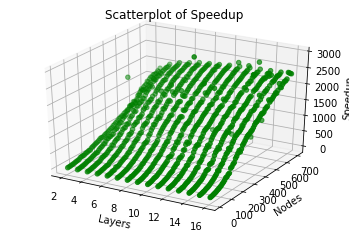

In [15]:
%matplotlib inline
  
# creating random dataset
xs = data['Layers']
ys = data['Nodes']
zs = data['Speedup']
  
# creating figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
  
# creating the plot
plot_geeks = ax.scatter(xs, ys, zs, color='green')
  
# setting title and labels
ax.set_title("Scatterplot of Speedup")
ax.set_xlabel('Layers')
ax.set_ylabel('Nodes')
ax.set_zlabel('Speedup')
  
# displaying the plot
plt.show()

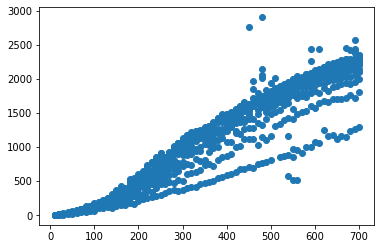

In [16]:
plt.scatter(data['Nodes'], data['Speedup'])

Here, lest connect the dataframes to R and do some multiple regression

In [17]:
%load_ext rpy2.ipython


Call:
lm(formula = Speedup ~ Layers + nodes_layers + Nodes + layers_sq + 
    nodes_sq, data = input)

Residuals:
     Min       1Q   Median       3Q      Max 
-1440.51   -70.52    13.61    75.15  1281.27 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -5.895e+02  3.112e+01 -18.943  < 2e-16 ***
Layers        9.796e+01  5.717e+00  17.134  < 2e-16 ***
nodes_layers  7.720e-02  5.541e-03  13.934  < 2e-16 ***
Nodes         3.203e+00  1.091e-01  29.353  < 2e-16 ***
layers_sq    -5.033e+00  2.917e-01 -17.255  < 2e-16 ***
nodes_sq     -5.782e-04  1.325e-04  -4.363 1.41e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 156.7 on 1044 degrees of freedom
Multiple R-squared:  0.956,	Adjusted R-squared:  0.9558 
F-statistic:  4541 on 5 and 1044 DF,  p-value: < 2.2e-16



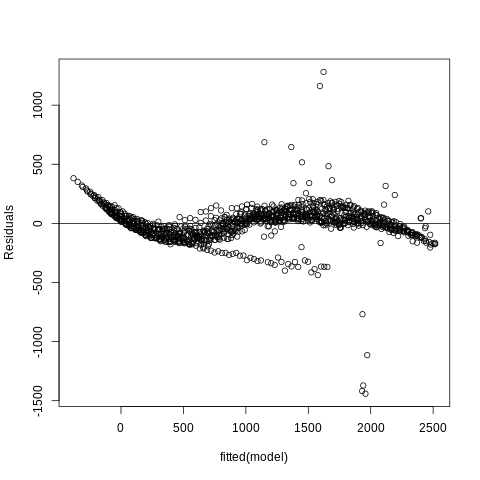

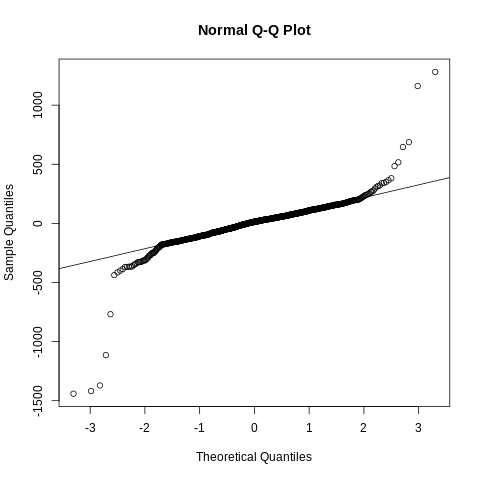

In [18]:
%%R -i data

input = data[,c("Layers", "Nodes", "Speedup")]
input$layers_sq = input$Layers^2
input$nodes_sq = input$Nodes^2
input$nodes_layers = input$Nodes * input$Layers
model = lm(Speedup~Layers+nodes_layers+Nodes+layers_sq+nodes_sq, data = input)

print(summary(model))

Residuals = resid(model)
plot(fitted(model), Residuals)
abline(0,0)
qqnorm(Residuals)
qqline(Residuals)

# DEVICE INFO

In [1]:
%%writefile device.cu
#include <stdio.h>

void getDeviceInfo()
{
    // Get CUDA Device Properties
    printf("Device Specs...\n");
    int num_cuda_devices;
    cudaGetDeviceCount(&num_cuda_devices);
    for(int i = 0; i < num_cuda_devices; i++) 
    {
        printf("Device %d - \n", i);
        cudaDeviceProp prop;
        cudaGetDeviceProperties(&prop, i);
        printf("\tDevice Name: %s\n", prop.name);
        printf("\tMax Threads Per Block: %d\n", prop.maxThreadsPerBlock);
        printf("\tMax Threads Dim: %d\n", *prop.maxThreadsDim);
        printf("\tMax Grid Size: %d\n\n", *prop.maxGridSize);
    }
    printf("\n");
    printf("\n");
    printf("\n");
}//end getDeviceInfo

int main() {
    getDeviceInfo();
    return 0;
}

Writing device.cu


In [2]:
%%shell
nvcc -arch=sm_52 device.cu
./a.out

Device Specs...
Device 0 - 
	Device Name: Tesla P100-PCIE-16GB
	Max Threads Per Block: 1024
	Max Threads Dim: 1024
	Max Grid Size: 2147483647




